# Diabetes Prediction with Deep Learning

Part 1: EDA and Data Processing

Part 2: Data Processing Summary and Pipeline

Part 3: Classification with PyTorch

- **3.1** Neural Network Model (1 hidden layer with 16 units, ReLU)  
- **3.2** Neural Network Models: Various Architectures  
- **3.3** Neural Network Models: Various Architectures Comparison  
- **3.4** Optimizer Tuning for Best Architecture ([256, 128, 64, 32, 16], ReLU)  
- **3.4** Optimizer Comparison for Best Architecture ([256, 128, 64, 32, 16], ReLU)  
- **3.5** PyTorch Lightning for Best Architecture ([256, 128, 64, 32, 16], ReLU, SGD)  
- **3.5** PyTorch Manual and Lightning Comparison for Best Architecture ([256, 128, 64, 32, 16], ReLU, SGD)  
- **3.6** 1D Convolution  
- **3.7** 2D Convolution  
- **3.8** Conclusions: 2D Convolution and Edge Detection  

In [73]:
# Install packages
!pip install -U jupyterlab
!pip install -U jupyter
!pip install -U pandas
!pip install -U numpy
!pip install -U seaborn
!pip install -U matplotlib
!pip install plotly==5.15.0
!pip install -U scikit-learn
!pip install -U lightgbm
!pip install -U xgboost
!pip install torch torchvision torchaudio
!pip install pytorch-lightning

In [115]:
# Core Libraries
import copy
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Sklearn Utilities
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from scipy.stats import zscore

# PyTorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer

In [91]:
# Рelper functions

#Identify and print missing values
def indentify_missing_values(df):
    missing_count = df.isnull().sum()
    missing_percent = (missing_count / len(df)) * 100
    column_types = df.dtypes
    # Create a summary table
    missing_summary = pd.DataFrame({
        'Missing Values': missing_count,
        'Percent (%)': missing_percent,
        'Type': column_types
    })
    # Filter to show only columns with missing values
    missing_summary = missing_summary[missing_summary['Missing Values'] > 0]
    # Sort by highest % missing
    missing_summary = missing_summary.sort_values(by='Percent (%)', ascending=False)
    print (missing_summary)

#Identify and print 0 values
def identify_zero_values(df):
    zero_count = (df == 0).sum()
    zero_percent = (zero_count / len(df)) * 100
    column_types = df.dtypes

    # Create a summary table
    zero_summary = pd.DataFrame({
        'Zero Values': zero_count,
        'Percent (%)': zero_percent,
        'Type': column_types
    })

    # Filter to show only columns with at least one zero
    zero_summary = zero_summary[zero_summary['Zero Values'] > 0]

    # Sort by highest percentage of zeros
    zero_summary = zero_summary.sort_values(by='Percent (%)', ascending=False)

    print(zero_summary)

def prepare_data(filepath='pima-indians-diabetes.data.csv'):
    # 1. Load dataset
    column_names = [
        'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
        'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'
    ]
    df = pd.read_csv(filepath, names=column_names)

    # 2. Replace invalid zeros with median
    columns_to_clean = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    for col in columns_to_clean:
        median = df[df[col] != 0][col].median()
        df[col] = df[col].replace(0, median)

    # 3. Separate features and target
    X = df.drop('Outcome', axis=1).values
    y = df['Outcome'].values

    # 4. Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 5. Split into train/val/test
    X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

    # 6. Convert to PyTorch tensors
    return {
        'X_train': torch.tensor(X_train, dtype=torch.float32),
        'y_train': torch.tensor(y_train, dtype=torch.float32),
        'X_val': torch.tensor(X_val, dtype=torch.float32),
        'y_val': torch.tensor(y_val, dtype=torch.float32),
        'X_test': torch.tensor(X_test, dtype=torch.float32),
        'y_test': torch.tensor(y_test, dtype=torch.float32)
    }
        
# This class wraps the feature (X) and label (y) tensors so they can be used by a PyTorch DataLoader
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        # Save features and labels as object attributes
        self.X = X
        self.y = y

    def __len__(self):
        # Return the number of samples (needed by DataLoader)
        return len(self.X)

    def __getitem__(self, idx):
        # Return the feature and label at index 'idx'
        return self.X[idx], self.y[idx]

class DiabetesModel(nn.Module):
    def __init__(self, input_size, hidden_layers=[16], activation_fn=nn.ReLU):
        super(DiabetesModel, self).__init__()

        layers = []
        in_features = input_size

        for hidden_size in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(activation_fn())  # Create a new activation object
            in_features = hidden_size

        layers.append(nn.Linear(in_features, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class DiabetesLightningModel(pl.LightningModule):
    def __init__(self, input_size=8, hidden_layers=[128, 64, 32, 16], learning_rate=0.1):
        super().__init__()
        layers = []
        in_features = input_size
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())
            in_features = hidden_size
        layers.append(nn.Linear(in_features, 1))
        self.model = nn.Sequential(*layers)
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.model(x).squeeze()

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss_fn(logits, y)
        preds = torch.sigmoid(logits) > 0.5
        acc = (preds == y).float().mean()
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss_fn(logits, y)
        preds = torch.sigmoid(logits) > 0.5
        acc = (preds == y).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=self.learning_rate, momentum=0.9)

def train_model(model, train_loader, optimizer_factory, num_epochs=20):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optimizer_factory(model.parameters())  # this replaces optimizer_class(..., lr=...)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = torch.sigmoid(outputs) > 0.5
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%")

def train_model(model, train_loader, val_loader, optimizer_factory, num_epochs=20):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optimizer_factory(model.parameters())
    best_f1 = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            predicted = torch.sigmoid(outputs) > 0.5
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_f1 = f1_score(all_labels, all_preds)

        # ---- Validation Phase ----
        model.eval()
        val_preds = []
        val_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs).squeeze()
                predicted = torch.sigmoid(outputs) > 0.5
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_f1 = f1_score(val_labels, val_preds)

        # ---- Save best model ----
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_state = copy.deepcopy(model.state_dict())

        print(f"Epoch [{epoch+1}/{num_epochs}], Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}")

    print(f"\nBest Validation F1 Score: {best_f1:.4f}")
    return best_model_state

In [4]:
# Import dataset

# Define column names
column_names = [
    'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
    'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'
]

# Load dataset with headers
df = pd.read_csv(
    'pima-indians-diabetes.data.csv',
    names=column_names
)

## 1. EDA and Data Processing

In [5]:
# Display dataset info

print(df.shape)
print(df.head())  # Preview first rows
print(df.info())  # Check data types

(768, 9)
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose             

In [9]:
# Analyze variance

# Check variance for each numerical column
variances = df.var()

# Display variances sorted from lowest to highest
variances.sort_values()

DiabetesPedigreeFunction        0.109779
Outcome                         0.227483
Pregnancies                    11.354056
BMI                            62.159984
Age                           138.303046
SkinThickness                 254.473245
BloodPressure                 374.647271
Glucose                      1022.248314
Insulin                     13281.180078
dtype: float64

**Conclusion:** Several features such as Insulin, Glucose, BloodPressure, and SkinThickness show abnormally high variance, likely due to invalid zero entries, and should be cleaned before model training.

In [18]:
# Identify missing values
indentify_missing_values(df)
identify_zero_values(df)

Empty DataFrame
Columns: [Missing Values, Percent (%), Type]
Index: []
               Zero Values  Percent (%)     Type
Outcome                500    65.104167    int64
Insulin                374    48.697917    int64
SkinThickness          227    29.557292    int64
Pregnancies            111    14.453125    int64
BloodPressure           35     4.557292    int64
BMI                     11     1.432292  float64
Glucose                  5     0.651042    int64


**Conclusion:** The dataset contains medically invalid zero values in features like Insulin, SkinThickness, Glucose, BloodPressure, and BMI, which should be replaced with meaningful values (e.g., median) before model training.

In [20]:
# Cleaning invalid 0 values

# Columns where zero is invalid and should be replaced
columns_to_clean = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Replace zeros with NaN for KNN imputation
df[columns_to_clean] = df[columns_to_clean].replace(0, np.nan)

# Apply KNN imputer
imputer = KNNImputer(n_neighbors=5)
df[df.columns] = imputer.fit_transform(df)

# Round target column back to int (if needed)
df['Outcome'] = df['Outcome'].round().astype(int)

# Show zero value summary after cleaning
print("\nAfter KNN cleaning:")
print(identify_zero_values(df))


After KNN cleaning:
             Zero Values  Percent (%)     Type
Outcome              500    65.104167    int64
Pregnancies          111    14.453125  float64
None


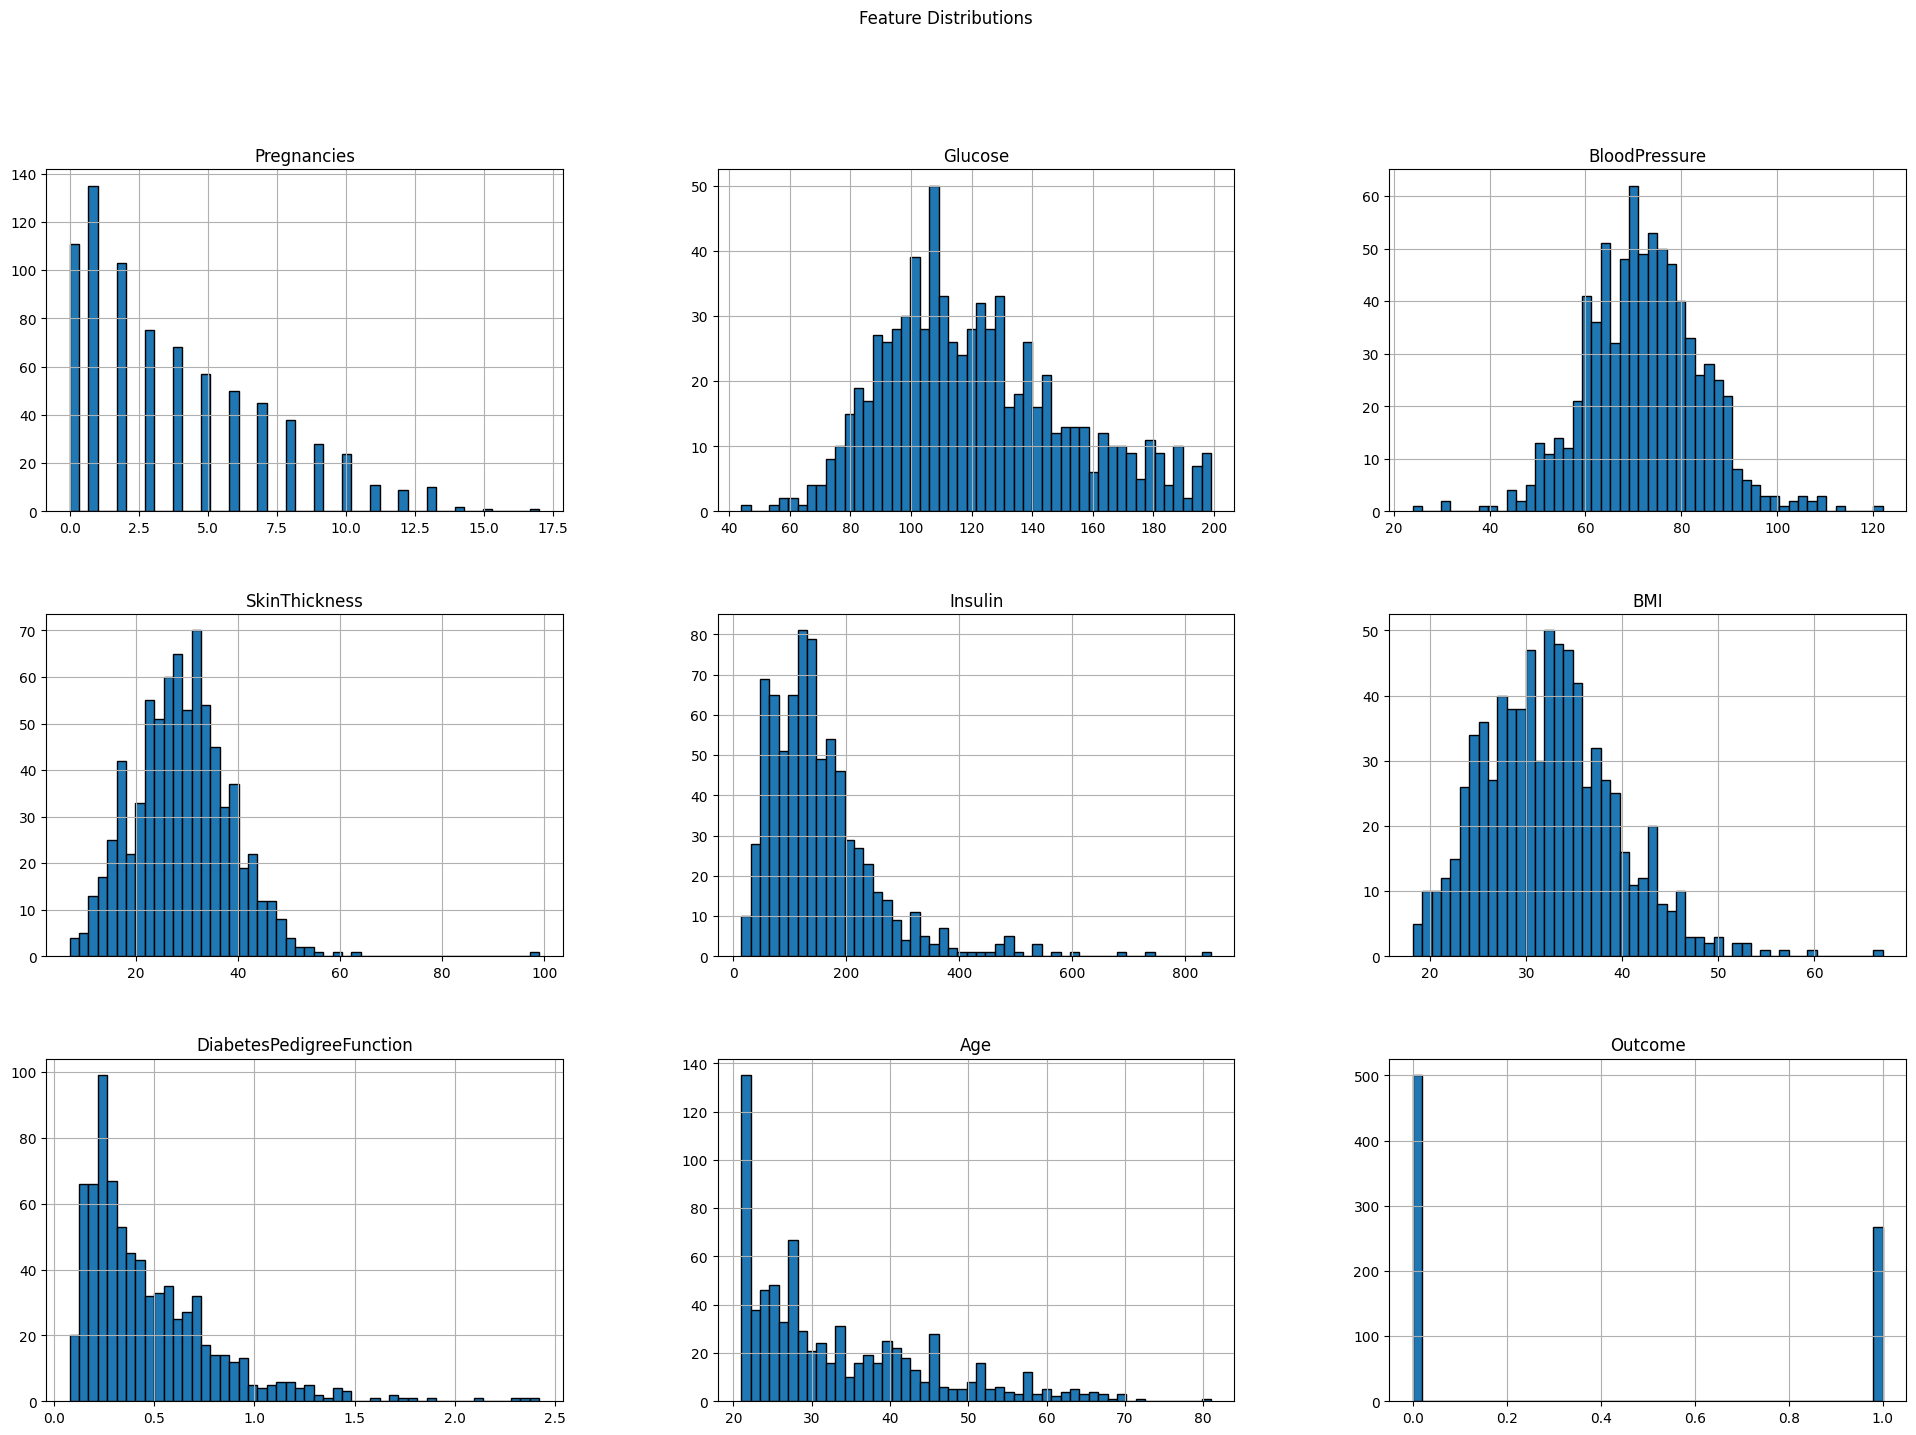

In [32]:
# Plot histograms for all numerical 
df.hist(figsize=(24, 16), bins=50, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=12)
plt.show()

Conclusion from Histograms:

- **Pregnancies, Insulin, DiabetesPedigreeFunction, Age**: Highly right-skewed; may benefit from log transformation or normalization for better model performance.
- **Glucose, SkinThickness, BMI, BloodPressure**: Roughly bell-shaped; scaling (e.g., StandardScaler) is sufficient.
- **Outcome**: Strong class imbalance (many 0s vs fewer 1s); consider using class weights or data balancing later.

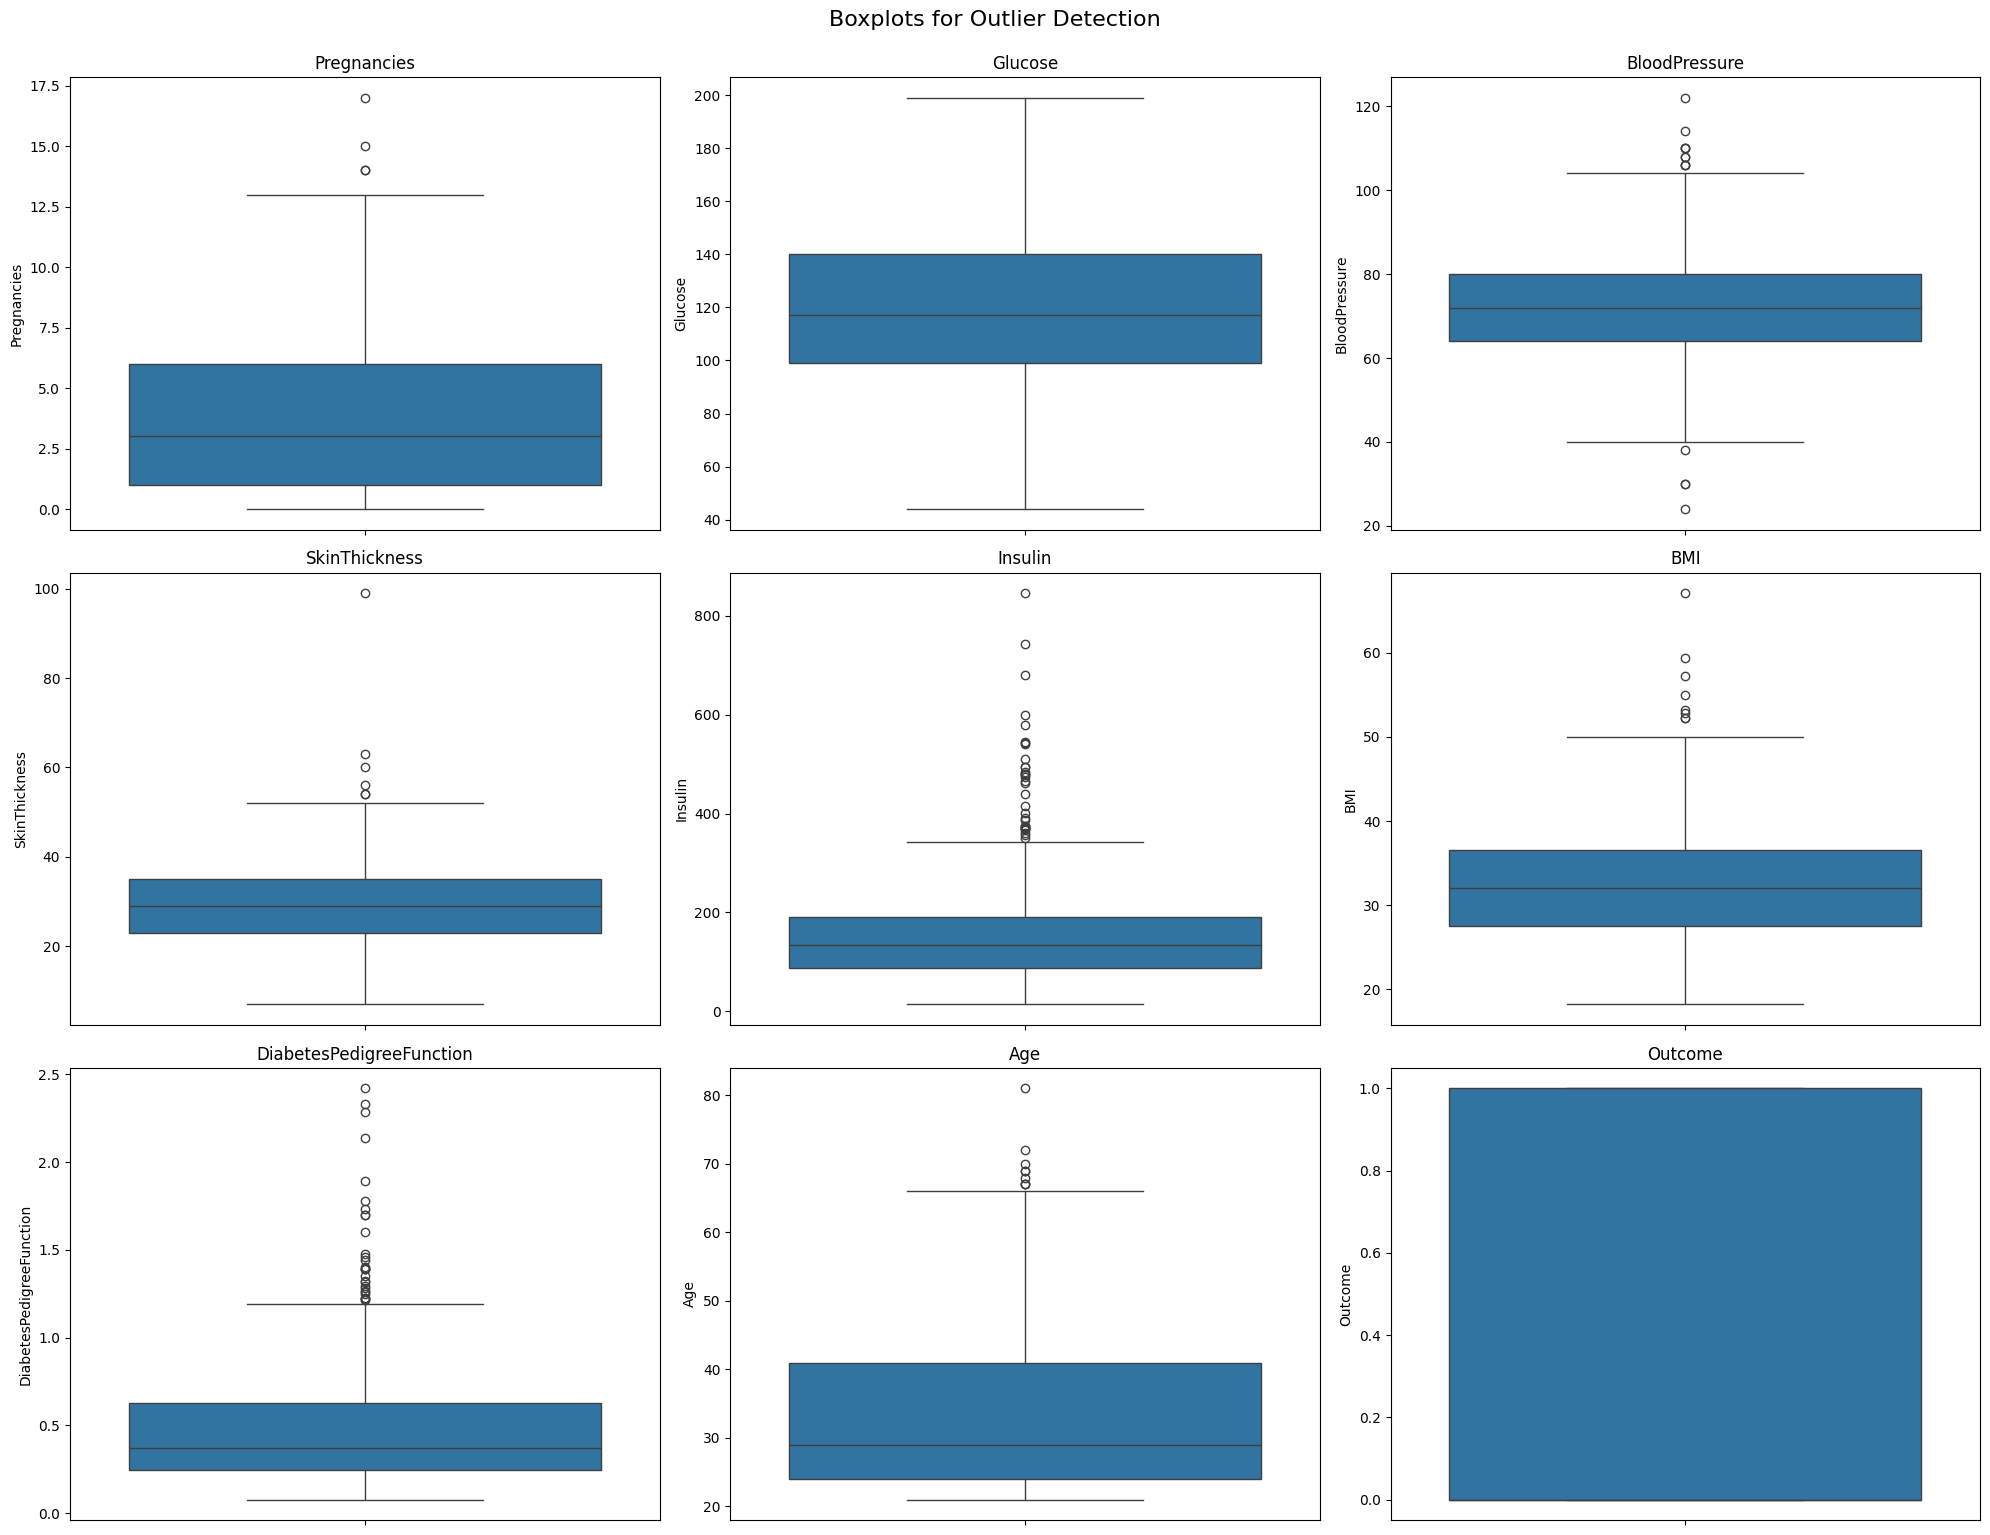

In [47]:
# Boxplots to visually inspect outliers for numeric features
numeric_cols = df.select_dtypes('number').columns

plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_cols):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.suptitle("Boxplots for Outlier Detection", fontsize=16, y=1.02)
plt.show()

In [53]:
# Z-score method to count values beyond |z| > 3
outlier_counts = {}

# For each numeric column, calculate Z-score and count |z| > 3
for col in numeric_cols:
    z = zscore(df[col])
    outlier_counts[col] = (abs(z) > 3).sum()

# Display sorted results
outlier_counts = pd.Series(outlier_counts).sort_values(ascending=False)

print("\nZ-Score Outlier Count (|z| > 3):")
print(outlier_counts)


Z-Score Outlier Count (|z| > 3):
BloodPressure               35
Insulin                     18
BMI                         14
DiabetesPedigreeFunction    11
Glucose                      5
Age                          5
Pregnancies                  4
SkinThickness                1
Outcome                      0
dtype: int64


In [52]:
# IQR method to count outliers beyond 1.5*IQR range
iqr_counts = {}
for col in numeric_cols:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
    iqr_counts[col] = len(outliers)

print("\nIQR Outlier Count (outside 1.5*IQR):")
print(pd.Series(iqr_counts).sort_values(ascending=False)) 


IQR Outlier Count (outside 1.5*IQR):
BloodPressure               45
Insulin                     34
DiabetesPedigreeFunction    29
BMI                         19
Age                          9
Glucose                      5
Pregnancies                  4
SkinThickness                1
Outcome                      0
dtype: int64


Outliers Analysis

**BloodPressure** and **Insulin** have a **large number of high outliers** (45 by IQR, 35 and 18 by Z-score respectively). These could affect model performance and should be considered for:
  - Removal
  - Capping (winsorization)
  - Log transformation

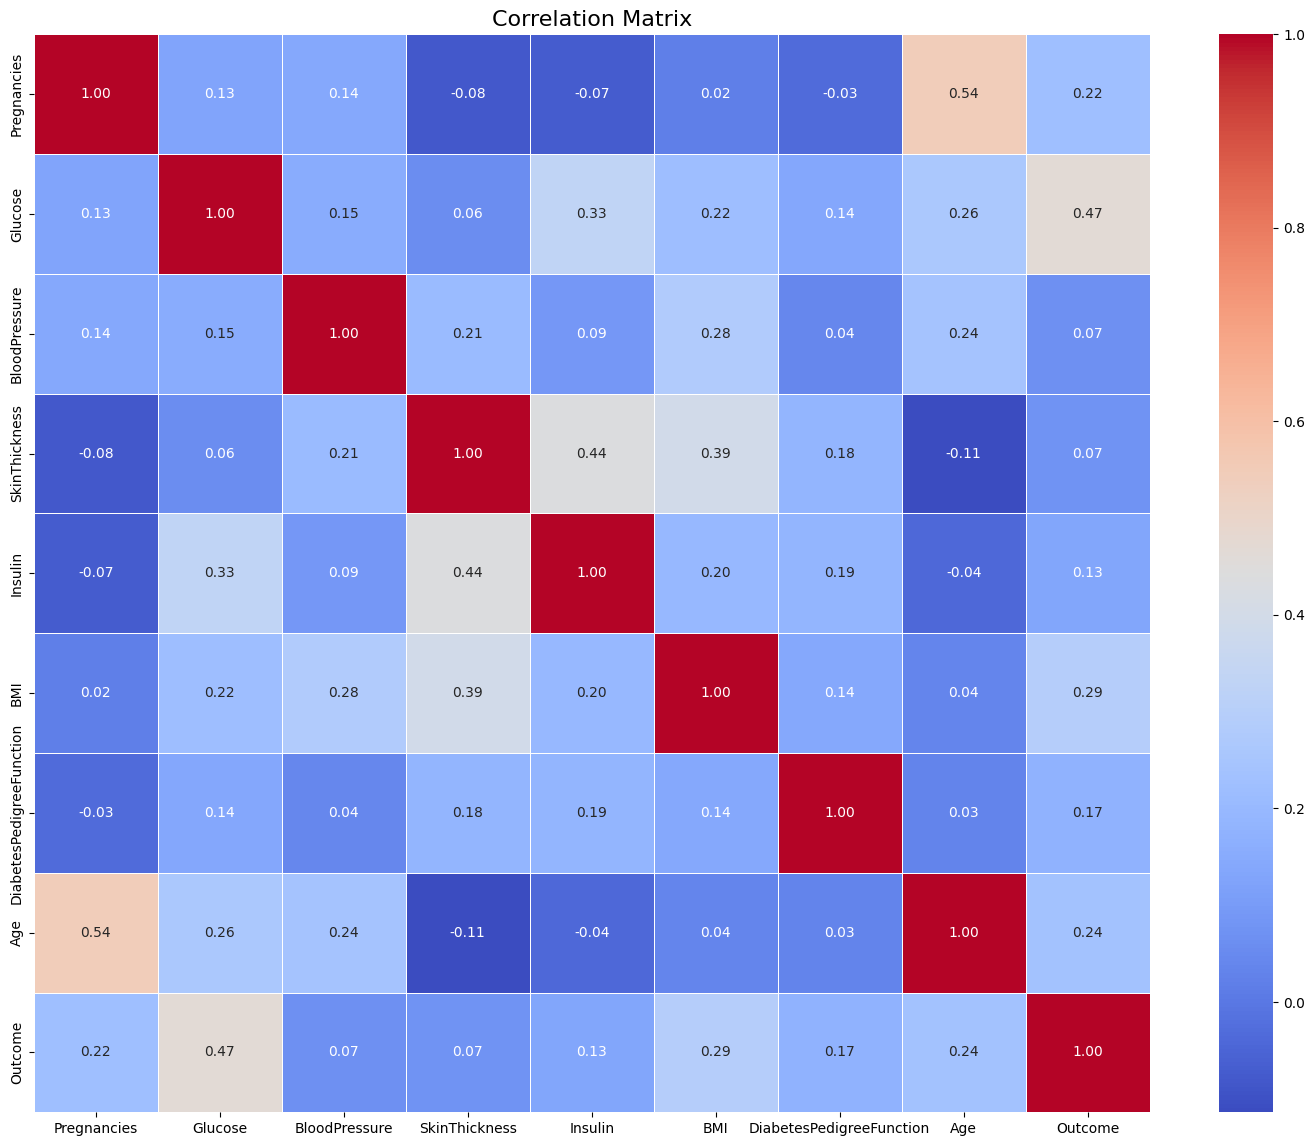

In [54]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Set the size of the heatmap
plt.figure(figsize=(18, 14))

# Create a heatmap with correlation values shown
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)

plt.title("Correlation Matrix", fontsize=16)
plt.show()

Correlation Matrix Analysis
- **Glucose** has the strongest positive correlation with **Outcome** (`0.47`), suggesting it's a key predictor of diabetes.
- There is **no multicollinearity** concern — no pair of features is highly correlated with each other (no values close to `1.0` off-diagonal), which is good for neural network modeling.

## 2. Data Processing Summary and Pipeline

- Import dataset and manually defined column names.
- No missing values (`NaN`) detected → no basic imputation needed.
- Replaced invalid zeros in `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, and `BMI` by **median**
- All features are numerical → use **standardization**.
- No highly correlated features → **no dimensionality reduction or feature removal** required.

Possible Improvements:
- Apply **log transformation** to right-skewed features: `Pregnancies`, `Insulin`, `DiabetesPedigreeFunction`, `Age`.
- Consider **log transformation or capping** for features with a large number of outliers: `BloodPressure`, `Insulin`.
- Use **normalization** insted of **standardization**
- Balance dataset
- Replaced invalid zeros in `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, and `BMI` by **KNN**

In [6]:
# 1. Import dataset and define column names
column_names = [
    'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
    'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'
]
df = pd.read_csv('pima-indians-diabetes.data.csv', names=column_names)

# 2. Replace invalid zeros with median
columns_to_clean = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in columns_to_clean:
    median = df[df[col] != 0][col].median()
    df[col] = df[col].replace(0, median)

# 3. Standardize all feature columns (excluding target)
features = df.drop('Outcome', axis=1)
target = df['Outcome']

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 4. Recombine scaled features with target
df_scaled = pd.DataFrame(features_scaled, columns=features.columns)
df_scaled['Outcome'] = target.reset_index(drop=True)

# Preview final dataset
print(df_scaled.head())

   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0     0.639947  0.866045      -0.031990       0.670643 -0.181541  0.166619   
1    -0.844885 -1.205066      -0.528319      -0.012301 -0.181541 -0.852200   
2     1.233880  2.016662      -0.693761      -0.012301 -0.181541 -1.332500   
3    -0.844885 -1.073567      -0.528319      -0.695245 -0.540642 -0.633881   
4    -1.141852  0.504422      -2.679076       0.670643  0.316566  1.549303   

   DiabetesPedigreeFunction       Age  Outcome  
0                  0.468492  1.425995        1  
1                 -0.365061 -0.190672        0  
2                  0.604397 -0.105584        1  
3                 -0.920763 -1.041549        0  
4                  5.484909 -0.020496        1  


## 3. Classification with Torch

### 3.1 Neural Network model (1 hidden layer with 16 units, ReLU)

In [110]:
# Load and preprocess the data
data = prepare_data()

# Wrap tensors in the custom Dataset class
train_dataset = DiabetesDataset(data['X_train'], data['y_train'])
val_dataset = DiabetesDataset(data['X_val'], data['y_val'])
test_dataset = DiabetesDataset(data['X_test'], data['y_test'])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model
model = DiabetesModel(input_size=data['X_train'].shape[1])

# Train and track best model
best_model_state = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer_factory=lambda params: optim.Adam(params, lr=0.001),
    num_epochs=20
)

# Load best model before testing
model.load_state_dict(best_model_state)

# Final test set evaluation
evaluate_model_on_test(model, test_loader)

Epoch [1/20], Train F1: 0.3476, Val F1: 0.3385
Epoch [2/20], Train F1: 0.3545, Val F1: 0.3889
Epoch [3/20], Train F1: 0.3963, Val F1: 0.4742
Epoch [4/20], Train F1: 0.4143, Val F1: 0.4598
Epoch [5/20], Train F1: 0.3984, Val F1: 0.5176
Epoch [6/20], Train F1: 0.4344, Val F1: 0.5176
Epoch [7/20], Train F1: 0.4340, Val F1: 0.5349
Epoch [8/20], Train F1: 0.4359, Val F1: 0.5349
Epoch [9/20], Train F1: 0.4473, Val F1: 0.5517
Epoch [10/20], Train F1: 0.4898, Val F1: 0.6154
Epoch [11/20], Train F1: 0.5159, Val F1: 0.6304
Epoch [12/20], Train F1: 0.5412, Val F1: 0.6383
Epoch [13/20], Train F1: 0.5560, Val F1: 0.6804
Epoch [14/20], Train F1: 0.5768, Val F1: 0.6875
Epoch [15/20], Train F1: 0.6014, Val F1: 0.6804
Epoch [16/20], Train F1: 0.5993, Val F1: 0.6804
Epoch [17/20], Train F1: 0.6071, Val F1: 0.6804
Epoch [18/20], Train F1: 0.6170, Val F1: 0.6804
Epoch [19/20], Train F1: 0.6316, Val F1: 0.6939
Epoch [20/20], Train F1: 0.6268, Val F1: 0.6804

Best Validation F1 Score: 0.6939

Test Loss: 0.5

### 3.2 Neural Network models: various architectures

In [111]:
# Load preprocessed data
data = prepare_data()

# Create Dataset wrappers
train_dataset = DiabetesDataset(data['X_train'], data['y_train'])
val_dataset = DiabetesDataset(data['X_val'], data['y_val'])
test_dataset = DiabetesDataset(data['X_test'], data['y_test'])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define architectures
architectures = [
    {"name": "Model 1: [16], ReLU", "model": DiabetesModel(8, [16], nn.ReLU)},
    {"name": "Model 2: [32, 16], ReLU", "model": DiabetesModel(8, [32, 16], nn.ReLU)},
    {"name": "Model 3: [64], LeakyReLU", "model": DiabetesModel(8, [64], nn.LeakyReLU)},
    {"name": "Model 4: [64, 32, 16], ReLU", "model": DiabetesModel(8, [64, 32, 16], nn.ReLU)},
    {"name": "Model 5: [128, 64, 32, 16], ReLU", "model": DiabetesModel(8, [128, 64, 32, 16], nn.ReLU)},
    {"name": "Model 6: [256, 128, 64, 32, 16], ReLU", "model": DiabetesModel(8, [256, 128, 64, 32, 16], nn.ReLU)},
    {"name": "Model 7: [256, 128, 64, 32, 16, 8], ReLU", "model": DiabetesModel(8, [256, 128, 64, 32, 16, 8], nn.ReLU)},
]

# Train and evaluate using validation set only
for config in architectures:
    print(f"\nTraining {config['name']}")
    model = config['model']
    train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer_factory=lambda params: optim.Adam(params, lr=0.001),
        num_epochs=20
    )

print("\nTraining complete. All validation F1 Scores have been printed.")


Training Model 1: [16], ReLU
Epoch [1/20], Train F1: 0.4915, Val F1: 0.5152
Epoch [2/20], Train F1: 0.4962, Val F1: 0.5443
Epoch [3/20], Train F1: 0.5433, Val F1: 0.6015
Epoch [4/20], Train F1: 0.5620, Val F1: 0.6435
Epoch [5/20], Train F1: 0.5833, Val F1: 0.6852
Epoch [6/20], Train F1: 0.5714, Val F1: 0.6792
Epoch [7/20], Train F1: 0.5467, Val F1: 0.6535
Epoch [8/20], Train F1: 0.5498, Val F1: 0.6667
Epoch [9/20], Train F1: 0.5606, Val F1: 0.6667
Epoch [10/20], Train F1: 0.5575, Val F1: 0.6596
Epoch [11/20], Train F1: 0.5520, Val F1: 0.6737
Epoch [12/20], Train F1: 0.5603, Val F1: 0.6809
Epoch [13/20], Train F1: 0.5603, Val F1: 0.6739
Epoch [14/20], Train F1: 0.5704, Val F1: 0.6667
Epoch [15/20], Train F1: 0.5745, Val F1: 0.6667
Epoch [16/20], Train F1: 0.5816, Val F1: 0.6667
Epoch [17/20], Train F1: 0.5836, Val F1: 0.6526
Epoch [18/20], Train F1: 0.6063, Val F1: 0.6316
Epoch [19/20], Train F1: 0.6132, Val F1: 0.6316
Epoch [20/20], Train F1: 0.6228, Val F1: 0.6458

Best Validation F1

### 3.3 Neural Network models: various architectures comparison

#### Architecture & Performance Summary

| Model      | Hidden Layers                     | Activation | Best Val F1 Score |
|------------|-----------------------------------|------------|-------------------|
| Model 1    | [16]                              | ReLU       | 0.6875            |
| Model 2    | [32, 16]                          | ReLU       | 0.6947            |
| Model 3    | [64]                              | LeakyReLU  | 0.7010            |
| Model 4    | [64, 32, 16]                      | ReLU       | 0.6947            |
| Model 5    | [128, 64, 32, 16]                 | ReLU       | 0.7027            |
| Model 6    | [256, 128, 64, 32, 16]            | ReLU       | **0.7222**        |
| Model 7    | [256, 128, 64, 32, 16, 8]         | ReLU       | 0.7115            |

---

#### Conclusion
- **Model 6** achieved the best **validation F1 score** of **0.7222**, indicating the most effective balance of precision and recall during training.

---

#### Key Insights
- Deeper architectures with more hidden layers generally performed better — up to a point.
- **Model 6** ([256, 128, 64, 32, 16]) stands out as the top-performing setup and may be the best candidate for final test evaluation.
- The use of **ReLU activation** showed stable performance across all tested configurations.
- Overly deep networks (like Model 7) did not significantly outperform Model 6 and might suffer from diminishing returns or training instability.

### 3.4 Optimizer Tuning for Best Architecture ([256, 128, 64, 32, 16], ReLU)

In [112]:
# Optimizer tuning for best architecture
optimizers = [
    {"name": "Adam (lr=0.001)", "factory": lambda params: optim.Adam(params, lr=0.001)},
    {"name": "Adam (lr=0.0005)", "factory": lambda params: optim.Adam(params, lr=0.0005)},
    {"name": "SGD (lr=0.1, momentum=0.9)", "factory": lambda params: optim.SGD(params, lr=0.1, momentum=0.9)},
    {"name": "RMSprop (lr=0.001)", "factory": lambda params: optim.RMSprop(params, lr=0.001)}
]

# Track results
optimizer_results = []

# Train and track validation F1 score
for opt in optimizers:
    print(f"\nOptimizer Test: {opt['name']}")
    model = DiabetesModel(input_size=8, hidden_layers=[256, 128, 64, 32, 16], activation_fn=nn.ReLU)
    best_state = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer_factory=opt["factory"],
        num_epochs=20
    )
    # Save name and best state for future use
    optimizer_results.append({"name": opt["name"], "model": model, "state_dict": best_state})

print("\nAll optimizers trained. Validation F1 Scores have been printed.")
print("You may now pick the best optimizer and evaluate on test set separately.")


Optimizer Test: Adam (lr=0.001)
Epoch [1/20], Train F1: 0.5154, Val F1: 0.6667
Epoch [2/20], Train F1: 0.5190, Val F1: 0.5610
Epoch [3/20], Train F1: 0.5578, Val F1: 0.7071
Epoch [4/20], Train F1: 0.6600, Val F1: 0.6727
Epoch [5/20], Train F1: 0.6954, Val F1: 0.6667
Epoch [6/20], Train F1: 0.7075, Val F1: 0.6733
Epoch [7/20], Train F1: 0.6667, Val F1: 0.6729
Epoch [8/20], Train F1: 0.6959, Val F1: 0.6237
Epoch [9/20], Train F1: 0.6923, Val F1: 0.6667
Epoch [10/20], Train F1: 0.7203, Val F1: 0.6237
Epoch [11/20], Train F1: 0.7266, Val F1: 0.6667
Epoch [12/20], Train F1: 0.7171, Val F1: 0.6471
Epoch [13/20], Train F1: 0.7219, Val F1: 0.6471
Epoch [14/20], Train F1: 0.7171, Val F1: 0.6408
Epoch [15/20], Train F1: 0.7267, Val F1: 0.6792
Epoch [16/20], Train F1: 0.7368, Val F1: 0.6731
Epoch [17/20], Train F1: 0.7344, Val F1: 0.6731
Epoch [18/20], Train F1: 0.7508, Val F1: 0.6535
Epoch [19/20], Train F1: 0.7532, Val F1: 0.6337
Epoch [20/20], Train F1: 0.7525, Val F1: 0.6847

Best Validation

### 3.4 Optimizer Comparison for Best Architecture ([256, 128, 64, 32, 16], ReLU)

| Optimizer  | Learning Rate     | Best Val F1 Score |
|------------|------------------|--------------------|
| Adam       | 0.001            | 0.7071             |
| Adam       | 0.0005           | 0.6809             |
| SGD        | 0.1 (momentum)   | **0.7213**         |
| RMSprop    | 0.001            | 0.7027             |

---

#### Conclusion

- **SGD with momentum (lr=0.1)** achieved the **highest validation F1 Score (0.7213)**, confirming it is the most effective optimizer for this deep neural architecture on the Pima Indians Diabetes dataset.

---

#### Key Insights

- **SGD with momentum** delivered the strongest validation performance, highlighting its effectiveness in structured, non-noisy datasets.

### 3.5 Pytorch Lightning for Best Architecture ([256, 128, 64, 32, 16], ReLU, SGD)

In [114]:
# Load Data
data = prepare_data()

train_dataset = DiabetesDataset(data['X_train'], data['y_train'])
val_dataset = DiabetesDataset(data['X_val'], data['y_val'])
test_dataset = DiabetesDataset(data['X_test'], data['y_test'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Train Lightning Model with best architecture and SGD optimizer
model = DiabetesLightningModel(
    input_size=8,
    hidden_layers=[256, 128, 64, 32, 16],
    learning_rate=0.1  # will be passed to SGD with momentum
)

trainer = Trainer(
    max_epochs=20,
    deterministic=True,
    log_every_n_steps=1,
    enable_progress_bar=True
)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# Evaluate on test set
evaluate_model_on_test(model, val_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | Sequential        | 46.1 K | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
------------------------------------------------------
46.1 K    Trainable params
0         Non-trainable params
46.1 K    Total params
0.184     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/opt/miniconda3/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.



Test Loss: 0.5180, F1 Score: 0.6392


### 3.5 PyTorch Manual and Lightning Comparison for Best Architecture: ([256, 128, 64, 32, 16], ReLU, SGD)

| Framework         | Optimizer           | Learning Rate     | Final F1 Score | Final Loss |
|------------------|---------------------|--------------------|----------------|------------|
| PyTorch (manual) | Adam                | 0.001              | 0.7037         |  —         |
| PyTorch (manual) | Adam                | 0.0005             | 0.6809         |  —         |
| PyTorch (manual) | SGD (momentum)      | 0.1                | **0.7213**     |  —         |
| PyTorch (manual) | RMSprop             | 0.001              | 0.7027         |  —         |
| Lightning        | SGD (momentum)      | 0.1                | 0.6392         | 0.5180     |

---

#### Conclusion

- **Manual PyTorch with SGD (lr=0.1, momentum=0.9)** achieved the highest validation F1 Score (**0.7213**), confirming its effectiveness for this deep architecture.
- **PyTorch Lightning** offered a simpler training pipeline and reached a decent F1 Score (**0.6392**), though slightly lower than the manual setup.
- The **F1 score gap (~8%)** suggests that Lightning’s default training loop may require further tuning (e.g., callbacks, scheduler, or early stopping) to match manual performance.

> **Recommendation**: Use **manual PyTorch with SGD** for maximum performance. Use **Lightning** for fast prototyping and clean project organization.

### 3.6 1D Convolution

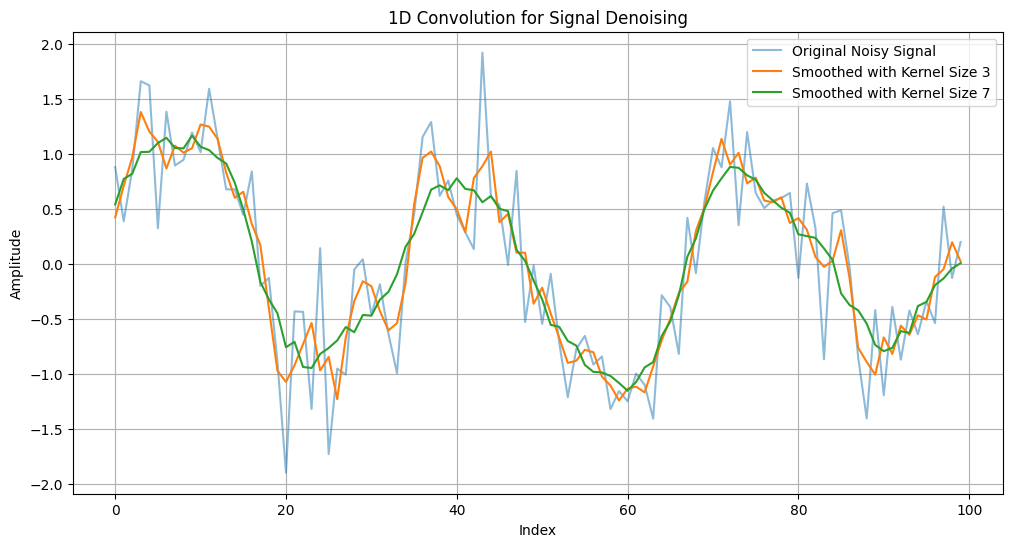

In [57]:
def convolve_1d(signal, kernel):
    signal = np.array(signal)
    kernel = np.array(kernel[::-1])  # Flip kernel for convolution

    pad_width = len(kernel) // 2
    padded_signal = np.pad(signal, pad_width, mode='constant')

    output = []
    for i in range(len(signal)):
        segment = padded_signal[i:i + len(kernel)]
        conv_value = np.sum(segment * kernel)
        output.append(conv_value)
    return np.array(output)

# Example: Denoise a noisy signal
np.random.seed(0)
x = np.linspace(0, 6*np.pi, 100)
noisy_signal = np.sin(x) + 0.5 * np.random.randn(100)

# Define two smoothing kernels of different sizes
kernel_3 = np.ones(3) / 3                   # Kernel of size 3: moving average [1/3, 1/3, 1/3]
kernel_7 = np.ones(7) / 7                   # Kernel of size 7: smoother average

smoothed_3 = convolve_1d(noisy_signal, kernel_3)
smoothed_7 = convolve_1d(noisy_signal, kernel_7)

# Plot original and smoothed
plt.figure(figsize=(12, 6))
plt.plot(noisy_signal, label='Original Noisy Signal', alpha=0.5)
plt.plot(smoothed_3, label='Smoothed with Kernel Size 3')
plt.plot(smoothed_7, label='Smoothed with Kernel Size 7')
plt.legend()
plt.title("1D Convolution for Signal Denoising")
plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

### 3.7 2D Convolution

In [58]:
def convolve2d_single_channel(image, kernel):
    kernel_height, kernel_width = kernel.shape
    image_height, image_width = image.shape

    # Calculate dimensions of the output image
    output_height = image_height - kernel_height + 1
    output_width = image_width - kernel_width + 1

    # Initialize an empty output array
    output = np.zeros((output_height, output_width))

    # Slide the kernel over the image
    for i in range(output_height):
        for j in range(output_width):
            # Extract the region of the image the kernel is currently on
            region = image[i:i+kernel_height, j:j+kernel_width]
            # Element-wise multiply and sum the result
            output[i, j] = np.sum(region * kernel)

    return output

def convolve2d_rgb(image, kernel):
    # Check if image is in correct format (3 channels)
    if image.ndim != 3 or image.shape[0] != 3:
        raise ValueError("Expected image shape (3, H, W) for RGB")

    convolved_channels = []

    # Apply convolution to each of the 3 channels separately
    for c in range(3):
        convolved = convolve2d_single_channel(image[c], kernel)
        convolved_channels.append(convolved)

    # Stack the 3 channels back into a 3D array
    return np.stack(convolved_channels)

# Example: A simple vertical edge detection kernel
example_kernel = np.array([
    [-1, -1, -1],
    [ 0,  0,  0],
    [ 1,  1,  1]
])

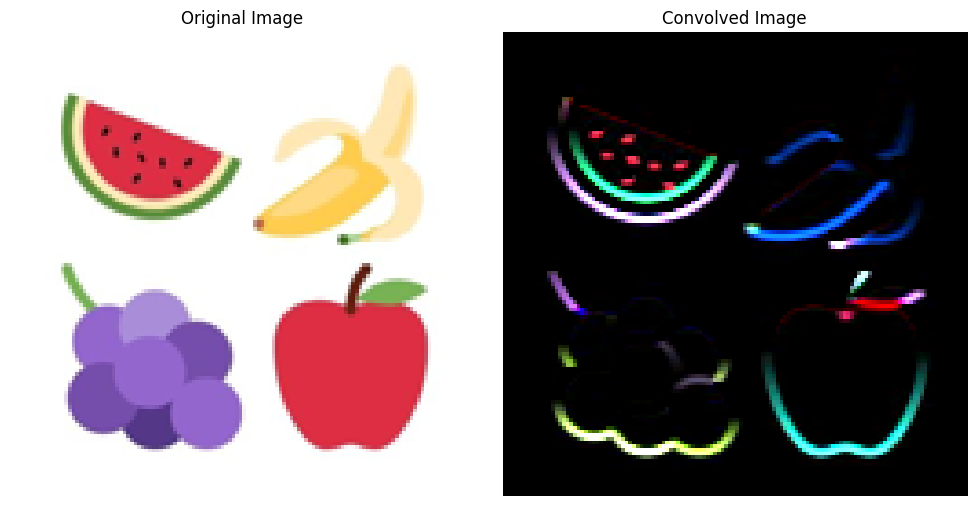

In [60]:
# Step 1: Load the image and resize for faster testing (optional)
image_path = 'sample.jpg'  # replace with your image file name
image = Image.open(image_path).convert('RGB')  # ensure it's RGB
image = image.resize((128, 128))  # resize to make it fast

# Step 2: Convert to numpy array and transpose to (C, H, W)
image_np = np.array(image)             # shape (H, W, 3)
image_np = image_np.transpose(2, 0, 1) # shape (3, H, W)

# Step 3: Normalize image to [0, 1] range for clarity (optional)
image_np = image_np / 255.0

# Step 4: Apply the custom convolution
convolved = convolve2d_rgb(image_np, example_kernel)

# Step 5: Clip values to [0, 1] and convert back to (H, W, 3) for plotting
convolved = np.clip(convolved, 0, 1)
convolved_display = convolved.transpose(1, 2, 0)  # (H, W, 3)

# Step 6: Show original and convolved images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(convolved_display)
plt.title("Convolved Image")
plt.axis('off')

plt.tight_layout()
plt.show()

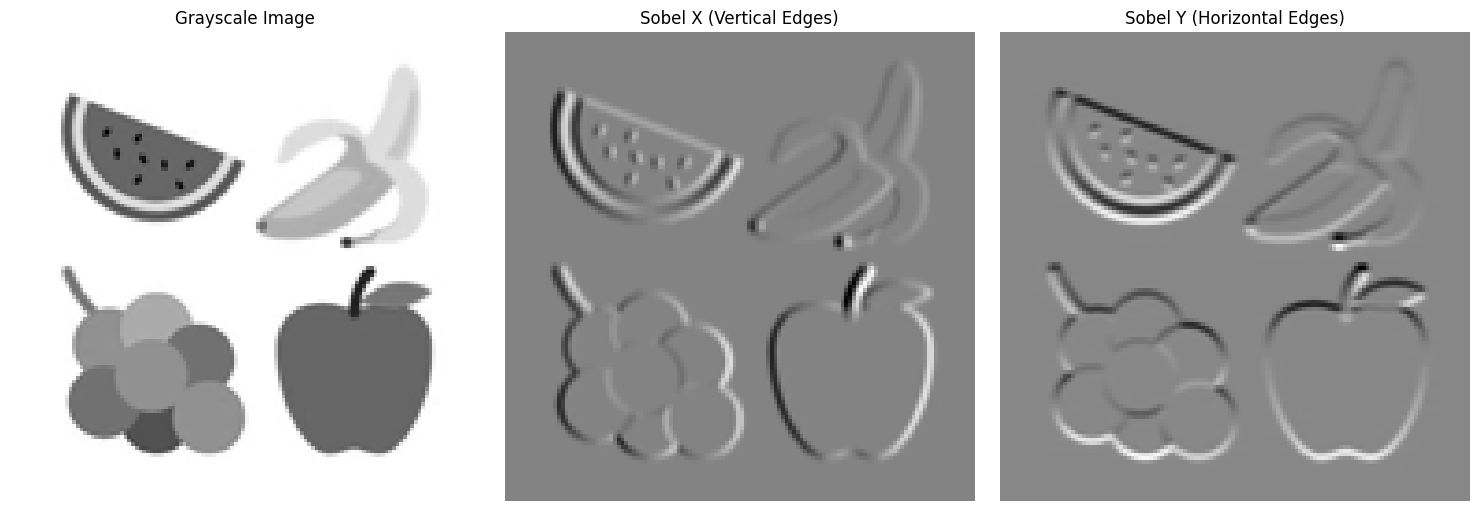

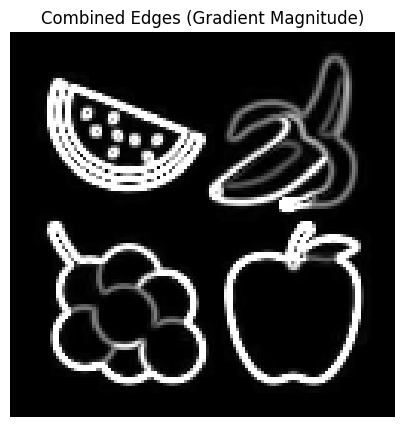

In [61]:
# Step 1: Convert the RGB image to grayscale (simple average)
gray_image = np.mean(image_np, axis=0)  # shape (H, W)

# Step 2: Define Sobel kernels for edge detection
sobel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

sobel_y = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
])

# Step 3: Apply convolution with both kernels
edges_x = convolve2d_single_channel(gray_image, sobel_x)
edges_y = convolve2d_single_channel(gray_image, sobel_y)

# Step 4: Combine the two edge maps (gradient magnitude)
edges_combined = np.sqrt(edges_x**2 + edges_y**2)
edges_combined = np.clip(edges_combined, 0, 1)

# Step 5: Show original grayscale and edge maps
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(gray_image, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(edges_x, cmap='gray')
plt.title("Sobel X (Vertical Edges)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(edges_y, cmap='gray')
plt.title("Sobel Y (Horizontal Edges)")
plt.axis('off')

plt.tight_layout()
plt.show()

# Optional: Show the combined edge magnitude image
plt.figure(figsize=(6, 5))
plt.imshow(edges_combined, cmap='gray')
plt.title("Combined Edges (Gradient Magnitude)")
plt.axis('off')
plt.show()

### 3.8 Conclusions: 2D Convolution and Edge Detection

1. Effect of Custom 2D Convolution
- Our hand-written convolution function worked successfully on both RGB and grayscale images.
- When applied to an RGB image using a basic edge detection kernel, the result highlights the color transitions where strong gradients exist.
- The edges in the convolved RGB image appeared as colorful outlines, showing how color differences between channels contribute to edge information.

2. Sobel Filter on Grayscale
- **Sobel X** detects **vertical edges** (e.g., outlines on the left/right of objects).
- **Sobel Y** detects **horizontal edges** (e.g., outlines on the top/bottom).
- Combining both using the gradient magnitude gives a clear and sharp edge map, ideal for tasks like object boundary detection or preprocessing before segmentation.

3. Conclusion
- These techniques are foundational for traditional image processing and are still valuable as preprocessing or interpretability tools in modern deep learning.
- In Convolutional Neural Networks (CNNs), the network learns such filters automatically, but understanding them manually builds strong intuition.

4. Trade-offs in Kernel Size
- A **larger kernel** can detect broader, smoother transitions but may miss fine details and increase computation.
- A **smaller kernel** (like 3x3) is better for capturing fine details and sharper edges but may be more sensitive to noise.